In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter

#from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score, classification_report, log_loss
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import scikitplot as skplt

import xgboost as xgb
#from xgboost import XGBClassifier

In [2135]:
#df_news = pd.read_pickle('/Users/otar/Google Drive/StocksAndNews/News.pkl')
df_news = pd.read_csv('/Users/otar/Google Drive/StocksAndNews/News.csv')
df_prices = pd.read_csv('/Users/otar/Google Drive/StocksAndNews/Prices_with_Trends.csv')

In [2136]:
df_news.shape, df_prices.shape

((93706, 12), (659410, 12))

In [2137]:
df_news.tail()

,ticker,release_date,level_0,index,id,article_id,neg,neu,pos,compound,news_amount,comp_aggr
93701,AMD,2020-02-05,179242.000000,220352.000000,441868.000000,1.012906e+08,0.0000,0.907500,0.092500,0.1806,2,0.3612
93702,AMD,2020-02-06,179197.500000,220307.500000,441823.500000,2.077960e+06,0.1755,0.665500,0.159000,0.1175,2,0.2350
93703,AMD,2020-02-11,179259.333333,220369.333333,441885.333333,1.343647e+08,0.0000,0.840333,0.159667,0.1858,3,0.5574
93704,AMD,2020-02-12,179291.000000,220401.000000,441917.000000,2.005071e+08,0.0000,0.833000,0.167000,0.2023,1,0.2023
93705,AMD,2020-02-13,179292.000000,220402.000000,441918.000000,2.005073e+08,0.3360,0.479000,0.185000,-0.2960,1,-0.2960


In [2138]:
df_prices.tail()

,Unnamed: 0,Date,High,Low,Open,Close,Volume,Adj Close,ticker,Next_day,Next_week,Next_month
659405,659405,2020-02-07,50.669998,48.639999,48.910000,49.730000,53107600.0,49.730000,AMD,50.994999,52.841999,52.841999
659406,659406,2020-02-10,52.299999,49.349998,49.470001,52.259998,60971700.0,52.259998,AMD,53.029999,53.619999,53.619999
659407,659407,2020-02-11,54.480000,52.910000,53.220001,53.799999,74719100.0,53.799999,AMD,53.844999,54.073332,54.073332
659408,659408,2020-02-12,54.849998,53.529999,54.529999,53.889999,45994900.0,53.889999,AMD,54.209999,54.209999,54.209999
659409,659409,2020-02-13,55.029999,53.340000,53.430000,54.529999,51640000.0,54.529999,AMD,54.529999,54.529999,54.529999


In [2139]:
# drop unnamed columns
#df_prices.drop(df_prices.columns[df_prices.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [2140]:
len(df_news.ticker.unique())

758

In [2141]:
#df_news.drop(['level_0'],axis=1, inplace=True)

In [2438]:
%%time
# calculate present/past trend for stock prices
tickers = df_news.ticker.unique()
#tickers = ['AMD', 'AAPL']
df_prices_new = pd.DataFrame()
for i in tickers:
    df_test = df_prices[df_prices.ticker==i].reset_index()
    df_test['100ma_pct'] = (df_test['Adj Close'] - 
                       df_test['Adj Close'].rolling(window=100, min_periods=0).mean()) / df_test['Adj Close']    
    df_test['60ma_pct'] = (df_test['Adj Close'] - 
                       df_test['Adj Close'].rolling(window=60, min_periods=0).mean()) / df_test['Adj Close']
    df_test['30ma_pct'] = (df_test['Adj Close'] - 
                       df_test['Adj Close'].rolling(window=30, min_periods=0).mean()) / df_test['Adj Close']
    df_test['7ma_pct'] = (df_test['Adj Close'] - 
                      df_test['Adj Close'].rolling(window=7, min_periods=0).mean()) / df_test['Adj Close']
    df_test['2ma_pct'] = (df_test['Adj Close'] - 
                      df_test['Adj Close'].rolling(window=2, min_periods=0).mean()) / df_test['Adj Close']
    
    df_test['100ma'] = df_test['Adj Close'].rolling(window=100, min_periods=0).mean()    
    df_test['60ma'] = df_test['Adj Close'].rolling(window=60, min_periods=0).mean()
    df_test['30ma'] = df_test['Adj Close'].rolling(window=30, min_periods=0).mean()
    df_test['7ma'] = df_test['Adj Close'].rolling(window=7, min_periods=0).mean()
    df_test['2ma'] = df_test['Adj Close'].rolling(window=2, min_periods=0).mean()
    
    df_test['30ma_vol'] = df_test['Volume'].rolling(window=30, min_periods=0).mean()
    df_test['7ma_vol'] = df_test['Volume'].rolling(window=7, min_periods=0).mean()
    df_test['2ma_vol'] = df_test['Volume'].rolling(window=2, min_periods=0).mean()
    
    if df_prices_new.empty:
        df_prices_new = df_test
    else:
        df_prices_new = df_prices_new.append(df_test, ignore_index=True, sort=False)

CPU times: user 1min 40s, sys: 41.7 s, total: 2min 21s
Wall time: 2min 25s


In [2439]:
#df_test[df_test.ticker=='AMD']
#df_prices_new.head()
#df_prices_new.drop(['index'],axis=1, inplace=True)
df_prices_new.head()
#df_prices_new.Close.describe()
#df_prices_new[df_prices_new.ticker=='AAPL']

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker,Next_day,...,7ma_pct,2ma_pct,100ma,60ma,30ma,7ma,2ma,30ma_vol,7ma_vol,2ma_vol
0,0,2018-09-12,6.93,5.35,6.00,6.60,66849000.0,6.60,NIO,9.10,...,0.000000,0.000000,6.600000,6.600000,6.600000,6.600000,6.60,6.684900e+07,6.684900e+07,66849000.0
1,1,2018-09-13,12.69,6.52,6.62,11.60,158346500.0,11.60,NIO,10.75,...,0.215517,0.215517,9.100000,9.100000,9.100000,9.100000,9.10,1.125978e+08,1.125978e+08,112597750.0
2,2,2018-09-14,13.80,9.22,12.66,9.90,172473600.0,9.90,NIO,9.20,...,0.053872,-0.085859,9.366667,9.366667,9.366667,9.366667,10.75,1.325564e+08,1.325564e+08,165410050.0
3,3,2018-09-17,9.75,8.50,9.61,8.50,56323900.0,8.50,NIO,8.09,...,-0.076471,-0.082353,9.150000,9.150000,9.150000,9.150000,9.20,1.134982e+08,1.134982e+08,114398750.0
4,4,2018-09-18,9.10,7.67,8.73,7.68,41827600.0,7.68,NIO,8.09,...,-0.153125,-0.053385,8.856000,8.856000,8.856000,8.856000,8.09,9.916412e+07,9.916412e+07,49075750.0


In [2440]:
df_prices_new.shape

(659410, 25)

In [2441]:
df_news.head()

,ticker,release_date,index,id,article_id,neg,neu,pos,compound,news_amount,comp_aggr
0,NIO,2018-09-12,62.0,221577.0,1606489.0,0.0,1.0,0.0,0.0,1,0.0
1,NIO,2018-09-14,61.0,221576.0,1610808.0,0.0,1.0,0.0,0.0,1,0.0
2,NIO,2018-09-24,60.0,221575.0,1621487.0,0.0,1.0,0.0,0.0,1,0.0
3,NIO,2018-10-03,54.0,221569.0,1632123.0,0.0,1.0,0.0,0.0,1,0.0
4,NIO,2018-10-09,75.0,221590.0,1637643.0,0.0,1.0,0.0,0.0,1,0.0


In [2442]:
%%time
# append and merge df_news and df_prices for all tickers
tickers = df_news.ticker.unique()
#tickers = ['AMD', 'AAPL']
main_df = pd.DataFrame()
for j in tickers:
    temp_news = df_news[df_news.ticker==j].reset_index()
    # calculate moving average of comp_aggr
    temp_news['30ma_comp'] = temp_news['comp_aggr'].rolling(window=30, min_periods=0).mean()
    temp_news['7ma_comp'] = temp_news['comp_aggr'].rolling(window=7, min_periods=0).mean()
    temp_news['2ma_comp'] = temp_news['comp_aggr'].rolling(window=2, min_periods=0).mean()
    
    temp_news.set_index('release_date', inplace=True)
    
    temp_prices = df_prices_new[df_prices_new.ticker==j].reset_index()
    #temp_prices['30ma_vol'] = temp_prices['Volume'].rolling(window=30, min_periods=0).mean()
    #temp_prices['7ma_vol'] = temp_prices['Volume'].rolling(window=7, min_periods=0).mean()
    #temp_prices['2ma_vol'] = temp_prices['Volume'].rolling(window=2, min_periods=0).mean()
    temp_prices.set_index('Date', inplace=True)
    
    temp_df = temp_news.merge(temp_prices, how='inner', left_index=True, right_index=True)
    if main_df.empty:
        main_df = temp_df.reset_index()
    else:
        main_df = main_df.append(temp_df.reset_index(), ignore_index=False, sort=False)

CPU times: user 47.5 s, sys: 7.21 s, total: 54.7 s
Wall time: 55.3 s


In [661]:
#temp_prices.set_index('Date', inplace=True)

In [798]:
#temp_df.tail()

In [689]:
#temp_news.set_index('release_date', inplace=True)
#temp_news.tail()

In [2443]:
#main_df.drop(['level_0_x','id','article_id', 'index_x'], axis=1, inplace=True)
#main_df.drop(['index_y'], axis=1, inplace=True)
main_df.tail()
#main_df.Close.describe()
#main_df[main_df.ticker_x=='AAPL'].Close

,index,level_0_x,ticker_x,index_x,id,article_id,neg,neu,pos,compound,...,2ma_pct,100ma,60ma,30ma,7ma,2ma,30ma_vol,7ma_vol,2ma_vol,release_date
140,2020-02-05,93701,AMD,220352.000000,441868.000000,1.012906e+08,0.0000,0.907500,0.092500,0.1806,...,0.003913,38.9657,44.184833,48.554666,48.732857,49.645000,5.437613e+07,6.308464e+07,44519600.0,NaN
141,2020-02-06,93702,AMD,220307.500000,441823.500000,2.077960e+06,0.1755,0.665500,0.159000,0.1175,...,-0.005272,39.1520,44.402000,48.683333,48.560000,49.580000,5.413560e+07,6.113133e+07,45703850.0,NaN
142,2020-02-11,93703,AMD,220369.333333,441885.333333,1.343647e+08,0.0000,0.840333,0.159667,0.1858,...,0.014312,39.7875,45.156167,49.231333,50.345714,53.029999,5.580967e+07,5.336931e+07,67845400.0,NaN
143,2020-02-12,93704,AMD,220401.000000,441917.000000,2.005071e+08,0.0000,0.833000,0.167000,0.2023,...,0.000835,40.0235,45.415167,49.510333,51.184285,53.844999,5.597118e+07,5.321473e+07,60357000.0,NaN
144,2020-02-13,93705,AMD,220402.000000,441918.000000,2.005073e+08,0.3360,0.479000,0.185000,-0.2960,...,0.005868,40.2683,45.681333,49.799333,51.909999,54.209999,5.663674e+07,5.397729e+07,48817450.0,NaN


In [2149]:
#main_df.to_csv('/Users/otar/Google Drive/StocksAndNews/train_0511.csv')
#main_df = pd.read_csv('/Users/otar/Google Drive/StocksAndNews/train_volume.csv')

In [225]:
#main_df.drop(['NDP'], axis=1, inplace=True)

In [2444]:
#main_df.NDP.tail()

In [2445]:
# pct change for next day, week and month
main_df['NDP'] = (main_df['Next_day'] - main_df['Adj Close']) / main_df['Adj Close']
main_df['NWP'] = (main_df['Next_week'] - main_df['Adj Close']) / main_df['Adj Close']
main_df['NMP'] = (main_df['Next_month'] - main_df['Adj Close']) / main_df['Adj Close']

In [2597]:
day_lim = 0.01
week_lim = 0.02
month_lim = 0.03
# create a list of our conditions
conditions_w = [
    (main_df['NWP'] > week_lim),
    (main_df['NWP'] >= -week_lim) & (main_df['NWP'] <= week_lim),
    (main_df['NWP'] < -week_lim) 
    ]

conditions_m = [
    (main_df['NMP'] > month_lim),
    (main_df['NMP'] >= -month_lim) & (main_df['NMP'] <= month_lim),
    (main_df['NMP'] < -month_lim) 
    ]

conditions_d = [
    (main_df['NDP'] > day_lim),
    (main_df['NDP'] >= -day_lim) & (main_df['NDP'] <= day_lim),
    (main_df['NDP'] < -day_lim) 
    ]
# create a list of the values we want to assign for each condition
values = [1,0,-1]
# create a new column and use np.select to assign values to it using our lists as arguments
main_df['label_day'] = np.select(conditions_d, values)
main_df['label_week'] = np.select(conditions_w, values)
main_df['label_month'] = np.select(conditions_m, values)

In [2599]:
#main_df.to_csv()
main_df.head()

,index,level_0_x,ticker_x,index_x,id,article_id,neg,neu,pos,compound,...,30ma_vol,7ma_vol,2ma_vol,release_date,NDP,NWP,NMP,label_day,label_week,label_month
0,2018-09-12,0,NIO,62.0,221577.0,1606489.0,0.0,1.0,0.0,0.0,...,6.684900e+07,6.684900e+07,66849000.0,NaN,0.378788,0.328598,0.137390,1,1,1
1,2018-09-14,1,NIO,61.0,221576.0,1610808.0,0.0,1.0,0.0,0.0,...,1.325564e+08,1.325564e+08,165410050.0,NaN,-0.070707,-0.148990,-0.259335,-1,-1,-1
2,2018-09-24,2,NIO,60.0,221575.0,1621487.0,0.0,1.0,0.0,0.0,...,6.842428e+07,5.580329e+07,15708200.0,NaN,-0.018424,-0.114199,-0.126163,-1,-1,-1
3,2018-10-03,3,NIO,54.0,221569.0,1632123.0,0.0,1.0,0.0,0.0,...,4.584785e+07,1.682101e+07,16345600.0,NaN,-0.003968,0.083929,0.079621,0,1,1
4,2018-10-09,4,NIO,75.0,221590.0,1637643.0,0.0,1.0,0.0,0.0,...,4.019068e+07,1.705263e+07,24986600.0,NaN,0.024357,0.030277,-0.056964,1,1,-1


In [2600]:
# filter for tickers with at least 200 entries (headlines) in the last 4 years (2016-2020)
tickers = main_df.ticker_x.unique()
df_m = main_df.reset_index()
for k in tickers:
    if df_m[df_m.ticker_x==k].count()[0]<200:
        df_m = df_m.drop(df_m[df_m.ticker_x==k].index)
    

In [2601]:
df_m.shape, main_df.shape

((36139, 48), (80733, 47))

In [2602]:
# list the remaining tickers
rows = []
tickers_new = df_m.ticker_x.unique()
for k in tickers_new:
     rows.append([df_m[df_m.ticker_x==k].count()[0], k])
print(rows[:3])

[[773, 'INTC'], [966, 'MSFT'], [612, 'MU']]


In [2603]:
(rows)

[[773, 'INTC'],
 [966, 'MSFT'],
 [612, 'MU'],
 [279, 'FCX'],
 [842, 'NFLX'],
 [317, 'BX'],
 [232, 'PM'],
 [648, 'GE'],
 [264, 'COST'],
 [971, 'GS'],
 [203, 'NDAQ'],
 [351, 'NKE'],
 [274, 'ASML'],
 [904, 'TSLA'],
 [226, 'ADBE'],
 [226, 'CBRE'],
 [200, 'HSY'],
 [256, 'NOC'],
 [207, 'MMM'],
 [460, 'TM'],
 [212, 'AZO'],
 [444, 'CMG'],
 [971, 'BAC'],
 [326, 'SLB'],
 [716, 'DIS'],
 [249, 'NLOK'],
 [776, 'XOM'],
 [487, 'KO'],
 [329, 'DAL'],
 [1020, 'AAPL'],
 [958, 'BA'],
 [392, 'SBUX'],
 [283, 'PG'],
 [336, 'PGR'],
 [584, 'TGT'],
 [254, 'AVGO'],
 [263, 'DUK'],
 [215, 'QCOM'],
 [562, 'BLK'],
 [264, 'STZ'],
 [206, 'HAS'],
 [497, 'CME'],
 [959, 'GOOGL'],
 [254, 'BIIB'],
 [211, 'KBH'],
 [456, 'LMT'],
 [290, 'HUM'],
 [256, 'JWN'],
 [305, 'ICE'],
 [246, 'BHC'],
 [381, 'AMGN'],
 [923, 'AMZN'],
 [220, 'BIDU'],
 [214, 'AXP'],
 [227, 'HD'],
 [264, 'FDX'],
 [264, 'CAT'],
 [284, 'LLY'],
 [440, 'IBM'],
 [335, 'SO'],
 [460, 'WMT'],
 [201, 'JBLU'],
 [205, 'UNH'],
 [245, 'COP'],
 [233, 'MA'],
 [434, 'CVX'],


# Create training and test data

In [2604]:
df_m.label_week.value_counts()

 0    24289
 1     6701
-1     5149
Name: label_week, dtype: int64

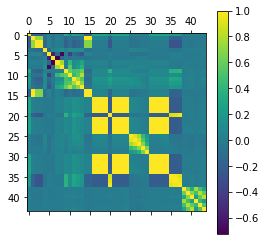

In [2605]:
plt.matshow(df_m.corr())
plt.colorbar()
plt.show()

In [2606]:
# create training set without tsla
df_m = df_m[df_m.ticker_x!='TSLA']

# Find correlation 

In [2607]:
#df_prices_new.head()

In [2608]:
#df_c = df_m[['index','ticker_x','Adj Close']]
df_c = df_prices_new[['Date','ticker','Adj Close']]
#df_c.head()

In [2609]:
df_co = df_c.groupby(['ticker','Date']).sum()
#df_co.head()

In [2610]:
df_co = df_co.unstack()
#df_co.head()

In [2611]:
#df_co = df_co.xs('index').transpose()
df_co = df_co.T

In [2612]:
#df_co.head()

In [2466]:
df_corr = df_co.corr()
#df_corr.iloc[0:10]

In [2613]:
df_corr_aapl = df_corr[df_corr['AAPL']>0.94]
df_corr_aapl.index[1:]

Index(['ANSS', 'ASML', 'GOOGL', 'JPM', 'MCO', 'MSFT', 'SHW', 'SNE', 'SPGI',
       'SYY'],
      dtype='object', name='ticker')

In [2614]:
# correlated to appl
corr_aapl_ticker = df_corr_aapl.index[1:]
df_apples = main_df[main_df['ticker_x'].isin(corr_aapl_ticker)]
df_apples.ticker_x.unique()

array(['MSFT', 'ASML', 'SHW', 'ANSS', 'SPGI', 'MCO', 'SNE', 'GOOGL',
       'SYY', 'JPM'], dtype=object)

In [2615]:
ind = df_m[df_m['ticker_x'].isin(corr_aapl_ticker)]
#ind
ind.ticker_x.unique()

array(['MSFT', 'ASML', 'GOOGL', 'JPM'], dtype=object)

In [2616]:
df_feature = main_df[main_df['ticker_x'].isin(corr_aapl_ticker)]
#df_feature.head()
df_feature[df_feature['index']=='2017-01-04']['30ma'].mean()

324.5014090643989

In [2617]:
%%time
# calculate 30ma from correlated companies
expl_tickers = df_m.ticker_x.unique()
com_list = expl_tickers
cor_mo = np.array([])
cor_we = np.array([])
cor_mo_comp = np.array([])
cor_mo_vol = np.array([])

for k in com_list:
    df_com = main_df[(main_df.ticker_x==k)]
    df_corr_com = df_corr[df_corr[k]>0.91]
    corr_com_ticker = df_corr_com.index[1:]
    df_sub = df_m[df_m['ticker_x'].isin(corr_com_ticker)]
    # for each date calculate the mean of 30ma and 7ma from the correlated companies
    for d in df_com['index']:
        cor_mo = np.append([cor_mo], [df_sub[df_sub['index']==d]['30ma_pct'].mean()])
        cor_we = np.append([cor_we], [df_sub[df_sub['index']==d]['7ma_pct'].mean()])
        cor_mo_comp = np.append([cor_mo_comp], [df_sub[df_sub['index']==d]['30ma_comp'].mean()])
        cor_mo_vol = np.append([cor_mo_vol], [df_sub[df_sub['index']==d]['30ma_vol'].mean()])
        

CPU times: user 2min 16s, sys: 465 ms, total: 2min 16s
Wall time: 2min 16s


In [2619]:
len(cor_mo), len(cor_we), len(cor_mo_comp), len(df_com), len(df_m)

(35235, 35235, 35235, 399, 35235)

In [2620]:
# add new feeatures to df 
df_m['30ma_pct_corr'] = cor_mo
df_m['7ma_pct_corr'] = cor_we
df_m['30ma_comp_corr'] = cor_mo_comp
df_m['30ma_vol_corr'] = cor_mo_vol
df_m = df_m.fillna(0)
#df_m.isna().sum()

In [2621]:
df_m.head()

,level_0,index,level_0_x,ticker_x,index_x,id,article_id,neg,neu,pos,...,NDP,NWP,NMP,label_day,label_week,label_month,30ma_pct_corr,7ma_pct_corr,30ma_comp_corr,30ma_vol_corr
363,0,2016-01-07,480,INTC,25435.0,246950.0,379114.0,0.0000,0.6590,0.341,...,-0.005182,-0.009501,-0.055403,0,0,-1,-0.027131,-0.027131,0.202369,1.963868e+07
364,1,2016-01-08,481,INTC,25436.0,246951.0,379325.0,0.2080,0.7920,0.000,...,0.008727,-0.008053,-0.048363,0,0,-1,-0.034422,-0.034422,-0.069040,2.479502e+07
365,2,2016-01-11,483,INTC,25437.0,246952.0,379494.0,0.0000,0.8160,0.184,...,0.009669,-0.032283,-0.066765,0,-1,-1,-0.025971,-0.025971,-0.126354,3.153547e+07
366,3,2016-01-12,484,INTC,25438.0,246953.0,379695.0,0.0000,0.5260,0.474,...,-0.011781,-0.058790,-0.086621,-1,-1,-1,-0.006198,-0.006198,-0.057988,2.016738e+07
367,4,2016-01-13,485,INTC,59272.0,280787.0,379816.5,0.1355,0.8645,0.000,...,0.013005,-0.048143,-0.067227,1,-1,-1,-0.031218,-0.027963,0.105724,1.431159e+07


In [2622]:
dat = df_corr.values

# Example plot of a company

In [2623]:
ex_comp = 'NFLX'
df_tsla = df_m[df_m.ticker_x==ex_comp][-120:]
#df_tsla = main_df[main_df.ticker_x==ex_comp]
#df_tsla.tail(10)
#df_tsla.Close.tail(10), df_tsla.Next_week.tail(10), df_tsla.NWP.tail(10)

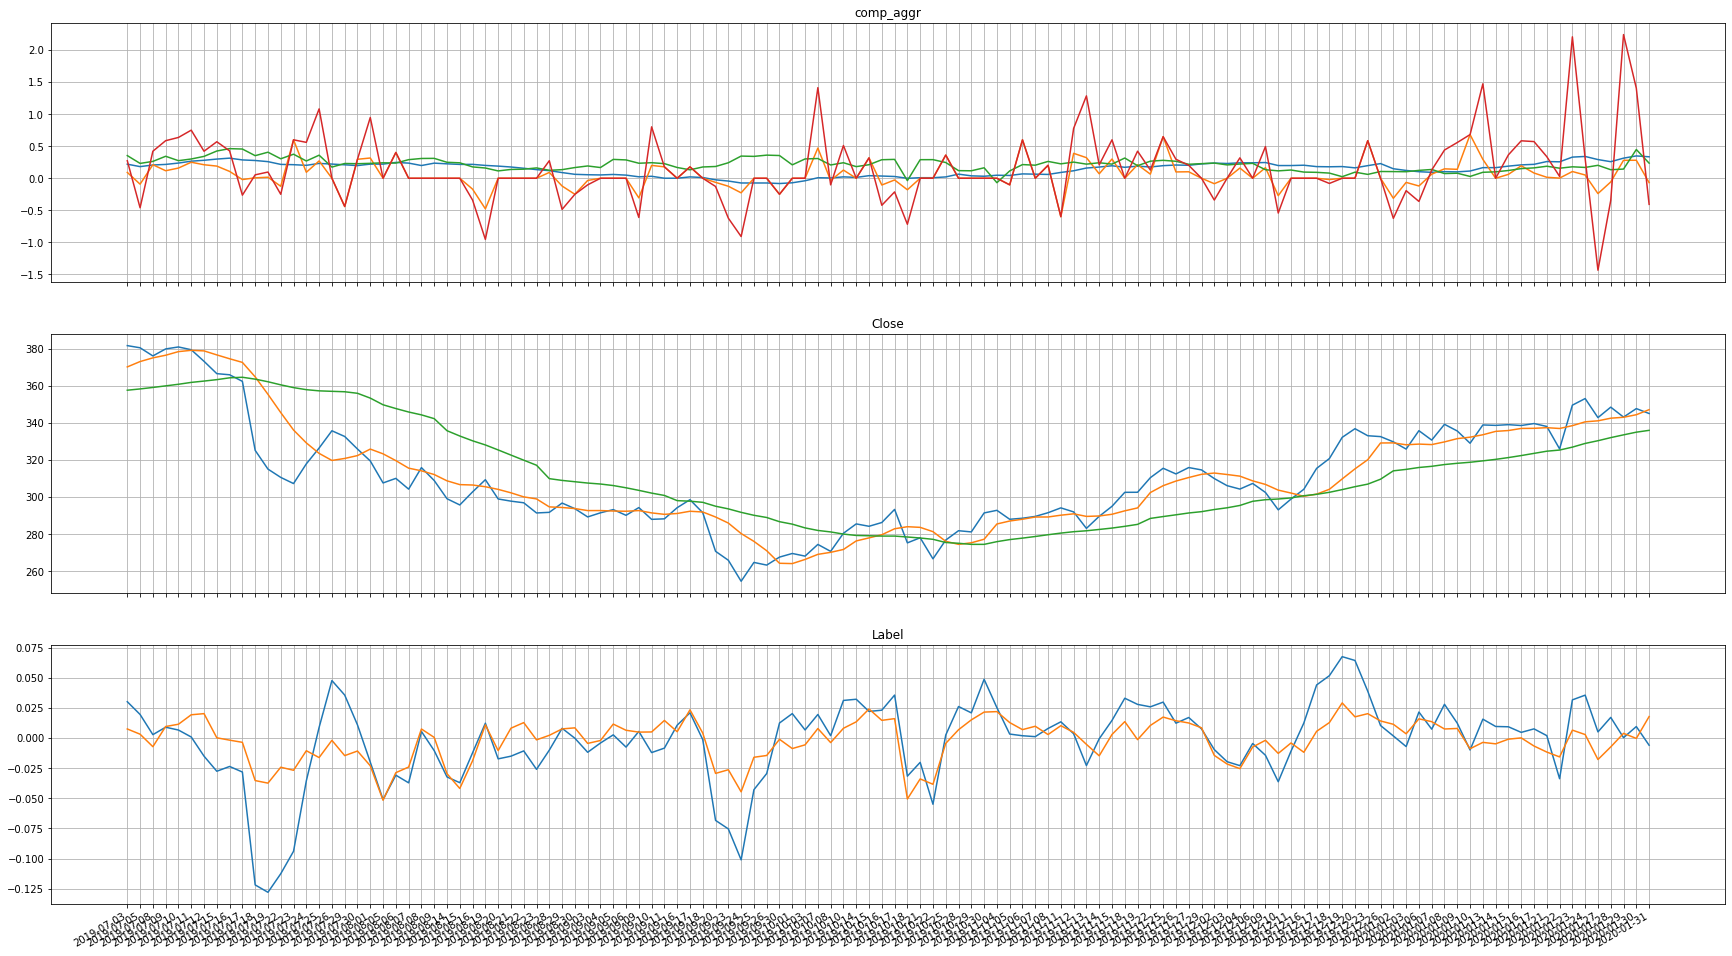

In [2647]:
# plot multiple graphs, visualizing different features
fig, axs = plt.subplots(3, 1, figsize=(30,18))
axs[0].plot(df_tsla['index'], df_tsla['30ma_comp'], df_tsla['index'], df_tsla['compound'],
           df_tsla['index'], df_tsla['30ma_comp_corr'], df_tsla['index'], df_tsla['comp_aggr'])
axs[0].set_title('comp_aggr', fontsize=12)
axs[0].grid(True)
#axs[0].set_xlabel('distance (m)')
#axs[0].set_ylabel('Damped oscillation')
#fig.suptitle('This is a somewhat long figure title', fontsize=16)

axs[1].plot(df_tsla['index'], df_tsla['Adj Close'], df_tsla['index'], df_tsla['7ma'], 
            df_tsla['index'], df_tsla['30ma'])
axs[1].set_title('Close', fontsize=12)
axs[1].grid(True)

#axs[2].plot(df_tsla['index'], df_tsla['2ma_vol'], df_tsla['index'], df_tsla['30ma_vol'])
axs[2].plot(df_tsla['index'], df_tsla['7ma_pct'], df_tsla['index'], df_tsla['7ma_pct_corr'])
axs[2].set_title('Label', fontsize=12)
axs[2].grid(True)

fig.autofmt_xdate()

# Resample data 

In [2650]:
# resample training data to get similar amount in the 3 labels

# Separate majority and minority classes
df_majority = df_m[df_m.label_week==0]
df_minority = df_m[df_m.label_week!=0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=35000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label_week.value_counts()

 0    23933
 1    19777
-1    15223
Name: label_week, dtype: int64

In [2651]:
#df_upsampled.to_csv('/Users/otar/Google Drive/StocksAndNews/data_resampled.csv')

In [2652]:
features = ['compound',
            '30ma', '7ma',
            '7ma_pct',
            '7ma_pct_corr',
            '7ma_comp']

def preprocess_for_ml(df):
    dfy = df['label_day']
    dfx = df[features]
    
    X_tr, X_te, y_tr, y_te = train_test_split(dfx, dfy, test_size=0.2, random_state=42)
    
    return X_tr, X_te, y_tr, y_te

In [2653]:
#dfx = main_df[(main_df.ticker_x=='AAPL')]
#dfx = main_df[main_df['ticker_x'].isin(['AAPL','GOOGL'])]
#dfx = main_df[main_df['ticker_x'].isin(corr_aapl_ticker)]
#dfx = df_m
dfx = df_m[df_m['ticker_x'].isin(corr_aapl_ticker)]
#dfx = df_upsampled
X_train, X_test, y_train, y_test = preprocess_for_ml(dfx)

In [2654]:
corr_aapl_ticker

Index(['ANSS', 'ASML', 'GOOGL', 'JPM', 'MCO', 'MSFT', 'SHW', 'SNE', 'SPGI',
       'SYY'],
      dtype='object', name='ticker')

In [2655]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2412, 6), (604, 6), (2412,), (604,))

In [2656]:
y_test.value_counts()

 0    548
-1     28
 1     28
Name: label_day, dtype: int64

In [2657]:
X_train.head()

,compound,30ma,7ma,7ma_pct,7ma_pct_corr,7ma_comp
76321,-0.003013,94.118147,94.960773,0.009989,0.016058,0.006986
76136,0.200950,104.206092,104.998087,0.008731,0.009075,0.496729
48769,-0.016133,799.650667,804.758571,-0.002452,0.002695,-0.066100
76564,0.158533,132.573632,130.850320,0.020734,0.007488,0.139100
49365,-0.031733,1193.944999,1211.519967,0.009168,0.003155,-0.312000


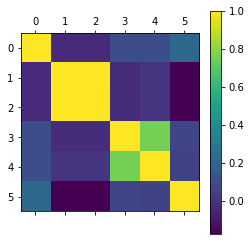

In [2658]:
X_train.corr()
plt.matshow(X_train.corr())
plt.colorbar()
plt.show()

# Random Forest

In [2659]:
def run_classifier(model, train_features, train_labels):
    print('Start model training')
    model.fit(train_features,train_labels)
    print('Model trained!')

In [2660]:
def evaluate(model, modelname, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = model.score(test_features, test_labels)*100
    errors = abs(predictions - test_labels)
    proba = model.predict_proba(test_features)
    
    print('Model Performance for:', modelname)
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print( Counter(predictions), Counter(test_labels))
    print('LOG_LOSS: ', log_loss(test_labels,proba))
    print('ROC_AUC_ovo: ', roc_auc_score(test_labels, proba, multi_class='ovo'))
    print('ROC_AUC_ovr: ', roc_auc_score(test_labels, proba, multi_class='ovr'))
    
    pd.Series(model.feature_importances_).nlargest(20).plot(kind='bar')
    
    return accuracy

In [2663]:
#clf = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=1, class_weight='balanced')
clf = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=1)
modelx = xgb.XGBClassifier(n_estimators=200, max_depth=10, random_state=1)
gb = GradientBoostingClassifier(n_estimators=200, max_depth=10, random_state=1)
#best_rf = RandomForestClassifier(n_estimators=2000, max_depth=50, random_state=1)

Start model training
Model trained!
Model Performance for: RF_base
Average Error: 0.0993 degrees.
Accuracy = 90.23%.
Counter({0: 600, 1: 3, -1: 1}) Counter({0: 548, -1: 28, 1: 28})
LOG_LOSS:  0.4046330443742102
ROC_AUC_ovo:  0.5654172252842743
ROC_AUC_ovr:  0.5834154018460587
CPU times: user 2.72 s, sys: 30.3 ms, total: 2.75 s
Wall time: 2.77 s


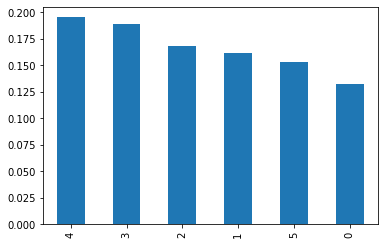

In [2664]:
%%time
run_classifier(clf, X_train, y_train)
clf_acc = evaluate(clf, 'RF_base', X_test, y_test)

# XGBOOST

Start model training
Model trained!
Model Performance for: XGB
Average Error: 0.1060 degrees.
Accuracy = 89.74%.
Counter({0: 592, 1: 9, -1: 3}) Counter({0: 548, -1: 28, 1: 28})
LOG_LOSS:  0.47291615827189104
ROC_AUC_ovo:  0.5312887928894185
ROC_AUC_ovr:  0.549532118960723
CPU times: user 2.68 s, sys: 31.2 ms, total: 2.71 s
Wall time: 2.79 s


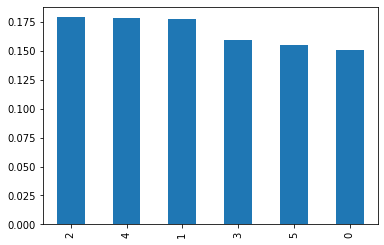

In [2638]:
%%time

run_classifier(modelx, X_train, y_train)
modelx_acc = evaluate(modelx, 'XGB', X_test, y_test)
#modelx.fit(X_train, y_train)

Start model training
Model trained!
Model Performance for: GBoost
Average Error: 0.1026 degrees.
Accuracy = 89.90%.
Counter({0: 594, -1: 6, 1: 4}) Counter({0: 548, -1: 28, 1: 28})
LOG_LOSS:  0.6704995831810666
ROC_AUC_ovo:  0.5692778936392074
ROC_AUC_ovr:  0.5821531458791952
CPU times: user 8.23 s, sys: 39.6 ms, total: 8.27 s
Wall time: 8.33 s


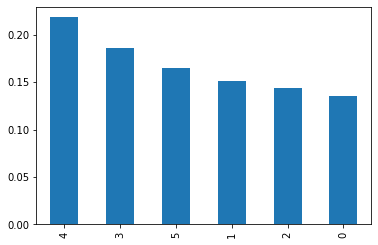

In [2639]:
%%time
run_classifier(gb, X_train, y_train)
gb_acc = evaluate(gb, 'GBoost', X_test, y_test)

In [1275]:
# Import your necessary dependencies
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [1318]:
model_f = modelx
rfe = RFE(model_f, 3)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 3
Selected Features: [False False False False False  True  True False False False  True False
 False False False False False]
Feature Ranking: [14 15 10 13 12  1  1  4  8 11  1  2  5  6  3  7  9]


# Test example

In [2640]:
def predict_for_test(model, df):
    dfy_val = df['label_day']
    dfx_val = df[features]
    
    
    predictions = model.predict(dfx_val)
    
    return predictions, dfy_val

In [2641]:
"""
Index(['ADBE', 'AMGN', 'ASML', 'AXP', 'BAC', 'BX', 'CBRE', 'CME', 'COST',
       'GOOGL', 'HD', 'HUM', 'JPM', 'LMT', 'MA', 'MCD', 'MSFT', 'NDAQ', 'NKE',
       'NOC', 'WMT'],
      dtype='object', name='ticker_x')
"""
#dfx = df_m[df_m['ticker_x'].isin(corr_aapl_ticker)]
ex_comp = ['AAPL']
#df_test = main_df[main_df.ticker_x==ex_comp][-120:]
df_test = df_m[df_m['ticker_x'].isin(ex_comp)]

pred_x, y_test = predict_for_test(clf, df_test)
#pred_x_x, y_test = predict_for_test(modelx, df_test)
#pred_x_gb, y_test = predict_for_test(gb, df_test)

In [2642]:
(y_test==pred_x).sum()/len(pred_x)

0.5637254901960784

In [2643]:
#(y_test==pred_x).sum()/len(pred_x),(y_test==pred_x_x).sum()/len(pred_x_x),(y_test==pred_x_gb).sum()/len(pred_x_gb)

In [2644]:
df_plot = df_test[-120:]
plot_x = pred_x[-120:]
plot_y = y_test[-120:]
df_plot.shape

(120, 52)

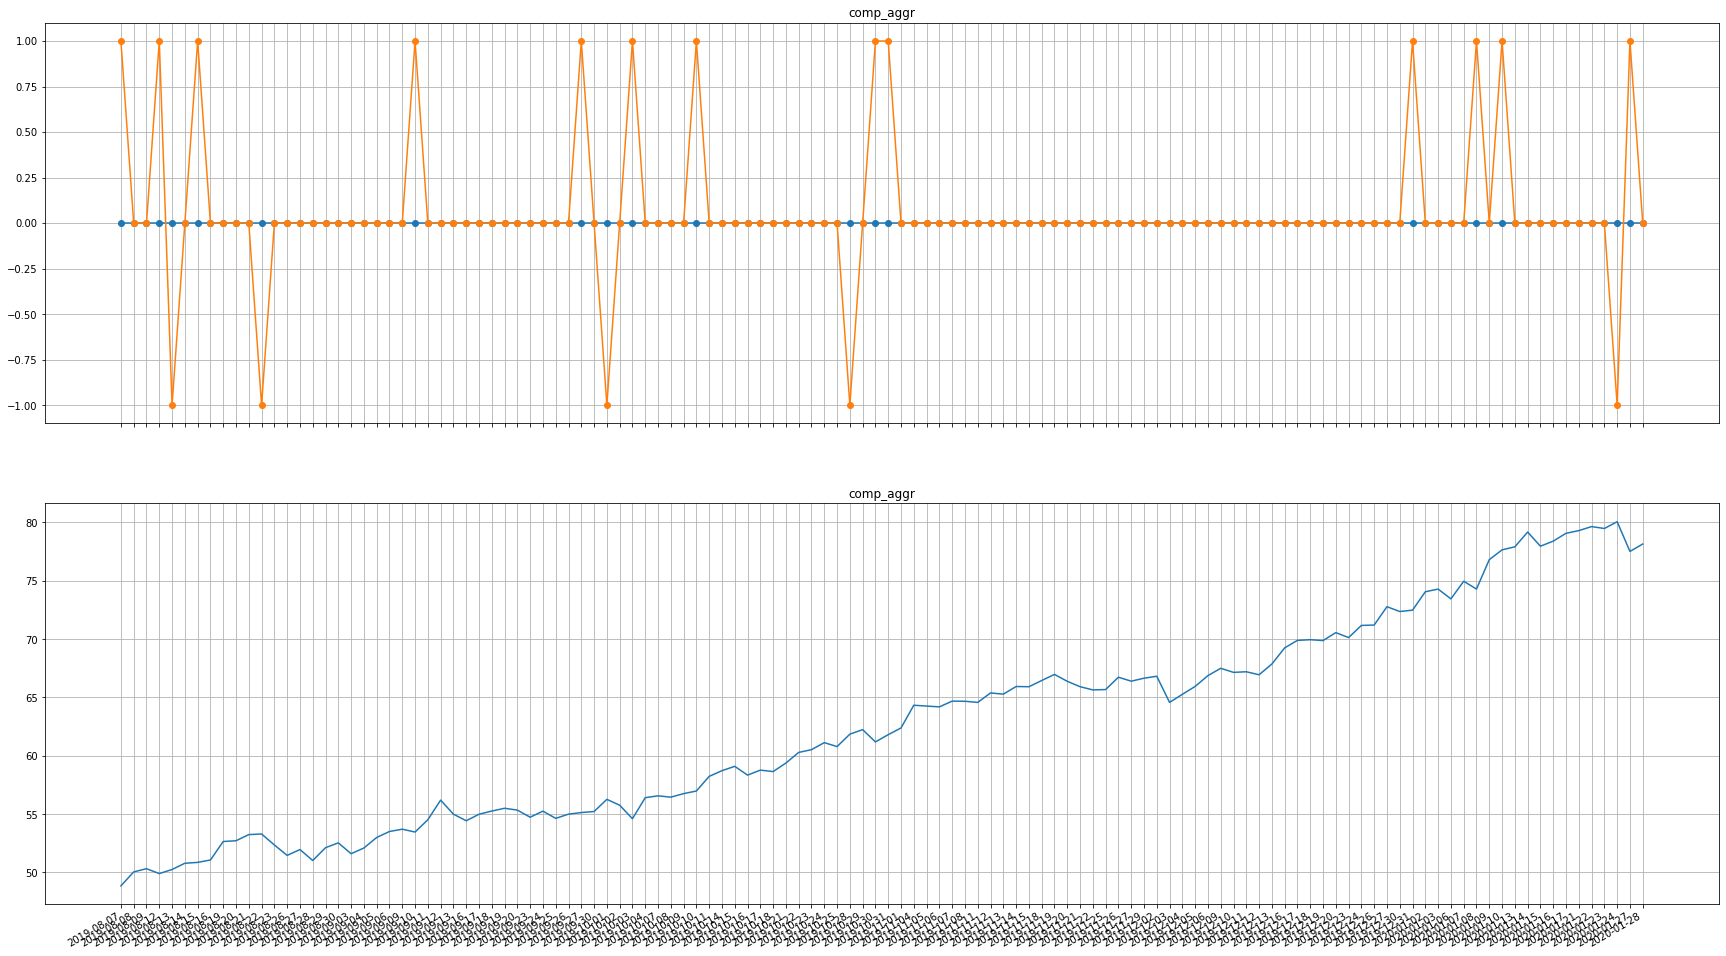

In [2645]:

# plot multiple graphs, visualizing different features
fig, axs = plt.subplots(2, 1, figsize=(30,18))
axs[0].plot(df_plot['index'], plot_x, df_plot['index'], plot_y, marker='o')
axs[0].set_title('comp_aggr', fontsize=12)
axs[0].grid(True)

axs[1].plot(df_plot['index'], df_plot['Open'])
axs[1].set_title('comp_aggr', fontsize=12)
axs[1].grid(True)


fig.autofmt_xdate()

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

# Gradient Boosting

In [52]:
%%time
gb.fit(X_train, y_train)

CPU times: user 6min 19s, sys: 2.93 s, total: 6min 22s
Wall time: 4min 40s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [53]:
pred_gb = gb.predict(X_test)

In [54]:
Counter(pred_gb), Counter(y_test)

(Counter({0: 9947, -1: 1363, 1: 616}), Counter({0: 6710, -1: 2923, 1: 2293}))

In [55]:
gb.score(X_test, y_test)

0.5862820727821566

In [56]:
proba_gb = gb.predict_proba(X_test)
#proba_gb, pred_gb

In [57]:
log_loss(y_test,proba_gb)

1.044434914633104

In [58]:
roc_auc_score(y_test, proba_gb, multi_class='ovo')

0.6646788896429009

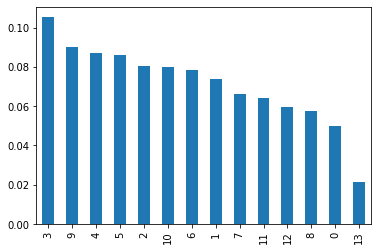

In [59]:
(pd.Series(gb.feature_importances_).nlargest(14).plot(kind='bar'))